<a href="https://colab.research.google.com/github/licTomasPerez/Spin-Chains-/blob/main/Colab_HS_proj_evol_me.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip
!pip install scipy
!pip install matplotlib.inline
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.7 MB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import pickle
import math, cmath

from IPython.display import display, Math, Latex

In [4]:
N = 3            # número de spines

h  = 1.0 * 2 * np.pi * np.ones(N) 
Jx = 0.15 * 2 * np.pi * np.ones(N)
Jy = 0.25 * 2 * np.pi * np.ones(N)
Jz = 0.1 * 2 * np.pi * np.ones(N)

In [29]:
id2 = qutip.qeye(2)
sx = .5*qutip.sigmax()
sy = .5*qutip.sigmay()
sz = .5*qutip.sigmaz()

def one_body_spin_ops(N):
    loc_sx_list = []
    loc_sy_list = []
    loc_sz_list = []
    for n in range(N):
        operator_list = []
        for m in range(N):
            operator_list.append(id2)
        operator_list[n] = sx
        loc_sx_list.append(qutip.tensor(operator_list))
        operator_list[n] = sy
        loc_sy_list.append(qutip.tensor(operator_list))
        operator_list[n] = sz
        loc_sz_list.append(qutip.tensor(operator_list))
    return loc_sx_list, loc_sy_list, loc_sz_list

def Heisenberg_hamiltonian (N, Jx, Jy, Jz, h, sx_list, sy_list, sz_list):
    H = 0;
    for n in range(N):
        H += -0.5*h[n]*sz_list[n]
        
    for n in range(N-1):
        H += -0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
        H += -0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
        H += -0.5 * Jz[n] * sz_list[n] * sz_list[n+1]
    return H

def free_particle_ops(N, sz_list):
    H_H = Heisenberg_hamiltonian (N, Jx, Jy, Jz, h, sx_list, sy_list, sz_list)
    loc_x_op = sum((.5 - sz_list[a])*(a+1) for a in range(N))
    loc_p_op = 1j * (loc_x_op*H_H - H_H*loc_x_op)
    loc_comm_xp = .5*(loc_x_op*loc_p_op + loc_p_op*loc_x_op)
    loc_corr_xp = -1j*(loc_x_op*loc_p_op - loc_p_op*loc_x_op)
    loc_p_dot = 1j*(H_H * loc_p_op - loc_p_op * H_H)
    return loc_x_op, loc_p_op, loc_comm_xp, loc_corr_xp, loc_p_dot

In [30]:
spin_list = one_body_spin_ops(N)
sx_list = spin_list[0]
sy_list = spin_list[1]
sz_list = spin_list[2]

In [31]:
H_H = Heisenberg_hamiltonian(N, Jx, Jy, Jz, h, sx_list, sy_list, sz_list)
H_H

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-4.86946861  0.          0.          0.07853982  0.          0.
   0.07853982  0.        ]
 [ 0.         -1.57079633 -0.31415927  0.          0.          0.
   0.          0.07853982]
 [ 0.         -0.31415927 -1.41371669  0.         -0.31415927  0.
   0.          0.        ]
 [ 0.07853982  0.          0.          1.57079633  0.         -0.31415927
   0.          0.        ]
 [ 0.          0.         -0.31415927  0.         -1.57079633  0.
   0.          0.07853982]
 [ 0.          0.          0.         -0.31415927  0.          1.72787596
  -0.31415927  0.        ]
 [ 0.07853982  0.          0.          0.          0.         -0.31415927
   1.57079633  0.        ]
 [ 0.          0.07853982  0.          0.          0.07853982  0.
   0.          4.55530935]]

In [32]:
## Free particles-Operators en términos de los operadores de spin
fplists = free_particle_ops(N, sz_list)

x_op = fplists[0]
p_op = fplists[1]
comm_xp = fplists[2]
corr_xp = fplists[3]

p_dot = fplists[4]

In [33]:
entropy_VN = []
def callback_entropy_VN (t,rhot):
    entropy_VN.append(qutip.entropy_vn(rhot))

In [34]:
def prod_basis(b1, b2):
    return [qutip.tensor(b,s) for b in b1 for s in b2]

def scalar_prod(op1, op2, rho0 = None):
    if op1.dims[0][0]!=op2.dims[0][0]:
        return "Incompatible Qobj dimensions"
    if rho0 is None:
        rho0 = qutip.qeye(op1.dims[0])/op1.dims[0][0]
    result = .5*(rho0*(op1*op2.dag()+op2.dag()*op1)).tr()
    result = result.real
    return result

def base_orth(ops, rho0):
    if isinstance(ops[0], list):
        ops = [op for op1l in ops for op in op1l]
      #print(type(ops),type(ops[0]))
    dim = ops[0].dims[0][0]
      #print("dim=",dim)
    basis = []
    for i, op in enumerate(ops): 
        alpha = [scalar_prod(op2, op, rho0) for op2 in basis]
        op_mod = op - sum([c*op2 for c, op2, in zip(alpha, basis)])
        op_norm = np.sqrt(scalar_prod(op_mod,op_mod,rho0))
        if op_norm<1.e-12:
            continue
        op_mod = op_mod/(op_norm)
        basis.append(op_mod)
    return basis

def logM(rho):
    eigvals, eigvecs = rho.eigenstates()
    return sum([np.log(vl)*vc*vc.dag() for vl, vc in zip(eigvals, eigvecs) if vl > 0])

def sqrtM(rho):
    eigvals, eigvecs = rho.eigenstates()
    return sum([(abs(vl)**.5)*vc*vc.dag() for vl, vc in zip(eigvals, eigvecs)])

def proj_op(K, basis, rho0):
    return sum([scalar_prod(b, K,rho0) * b for b in basis])

def rel_entropy(rho, sigma):
    val = (rho*(logM(rho)-logM(sigma))).tr()
    if abs(val.imag)>1.e-6:
        print("rho or sigma not positive")
        #print(rho.eigenstates())
        #print(sigma.eigenstates())
    return val.real

def bures(rho, sigma):
    val = abs((sqrtM(rho)*sqrtM(sigma)).tr())
    val = max(min(val,1.),-1.)
    return np.arccos(val)/np.pi
        
def maxent_rho(rho, basis):   
    def test(x, rho, basis):
        k = sum([-u*b for u,b in zip(x, basis)])        
        sigma = (.5*(k+k.dag())).expm()
        sigma = sigma/sigma.tr()
        return rel_entropy(rho, sigma)    
    res = opt.minimize(test,np.zeros(len(basis)),args=(rho,basis))
    k = sum([-u*b for u,b in zip(res.x, basis)])        
    sigma = (.5*(k+k.dag())).expm()
    sigma = sigma/sigma.tr()
    return sigma
 
def error_maxent_state(rho, basis, distance=bures):
    try:
        sigma = maxent_rho(rho, basis)
        return distance(rho,sigma)
    except:
        print("fail error max-ent state")
        return None
       
def error_proj_state(rho, rho0, basis, distance=bures):
    try:
        basis = base_orth(basis, rho0)
    except:
        print("orth error")
        raise
    try:
        sigma = proj_op(logM(rho), basis, rho0).expm()
        sigma = (sigma+sigma.dag())/(2.*sigma.tr())
    except:
        print("gram error")
    try:
        return distance(rho, sigma)
    except:
        print("fail error proj state")
        return None

def spin_dephasing(gamma):
    loc_c_op_list = []
    collapse_weights = gamma * np.ones(N)
    for n in range(N):
        if collapse_weights[n] > 0.0:
           loc_c_op_list.append(np.sqrt(collapse_weights[n]) * sz_list[n])
    return loc_c_op_list

In [35]:
# Estas definiciones quedaron obsoletas pero sirven para el testeo de la n_body_basis

globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])
globalid_list = []

one_site_basis = globalid_list + sx_list + sy_list + sz_list 
two_site_basis = [op1*op2 for op1 in one_site_basis for op2 in one_site_basis]

tercera_base = [op*op3 for op in two_site_basis for op3 in one_site_basis]
three_site_basis = [op1*op2*op3 for op1 in one_site_basis for op2 in one_site_basis for op3 in one_site_basis]

cuarta_base = [op*op4 for op in three_site_basis for op4 in one_site_basis]
four_site_basis = [op1*op2*op3*op4 for op1 in one_site_basis for op2 in one_site_basis for op3 in one_site_basis for op4 in one_site_basis]

In [36]:
# def isnatural(x):
#   return isinstance(x, int) and 0 <= x <= 9

## globalid_list tiene N operadores anidados
## sx_list, sy_list, sz_list ídem, N operadores c/u. 
## La 1-base completa tiene 4N operadores de 1-cuerpo
## La 2-base completa tiene 4N*{4N} operadores de 2-cuerpos
## La 3-base completa tiene {4N*{4N}}*4N} operadores 

for i in range(N):
    globalid_list.append(globalid)

natural = tuple('123456789')

def n_body_basis(n):
    basis = []
    if (isinstance(n,int) and str(n) in natural):
        if (n == 1):
            basis = globalid_list + sx_list + sy_list + sz_list
        elif (n > 1):
            basis = [op1*op2 for op1 in n_body_basis(n-1) for op2 in n_body_basis(1)]
    else:
        basis = 'beep boop, n must be natural'
    #return base_orth(basis, globalid)
    return basis

In [37]:
uno_a_cuatro_bases = []
uno_a_cuatro_bases.append(one_site_basis)
uno_a_cuatro_bases.append(two_site_basis)
uno_a_cuatro_bases.append(three_site_basis)
uno_a_cuatro_bases.append(four_site_basis)

def basis_defs_test():
    boolean = False 
    for n in range(4): 
        for m in range(3):
            if (n_body_basis(n+1) == uno_a_cuatro_bases[m] and n != m):
                print('Error: Two different index basis definitions equal', boolean)
            if (n_body_basis(n+1) != uno_a_cuatro_bases[m] and n == m):
                print('Error: Two same index basis definitions not equal', boolean)
            else:
                print('OK', True)
    return None

basis_defs_test()

Error: Two same index basis definitions not equal False
OK True
OK True
OK True
Error: Two same index basis definitions not equal False
OK True
OK True
OK True
Error: Two same index basis definitions not equal False
OK True
OK True
OK True


%%latex

Si quiero un estado gaussiano de operadores de un cuerpo, el más general es 

$$
\rho_{1,g} = \exp\bigg(\alpha I_N + {\bf a}_1 \cdot {\bf s}_x+{\bf a}_2 \cdot {\bf s}_y+{\bf a}_3 \cdot {\bf s}_z\bigg) 
$$

análogamente con estados gaussianos de operadores de dos cuerpos (pero ya ahí se me va al carajo).
Si en cambio, considero un estado no gaussiano, puedo considerar un estado inicial descorrelacionado de la forma de 

$$
\rho_0 = x |\Phi\rangle \langle\Phi| + (1-x)\frac{{I_d}}{d}
$$

In [38]:
coeff_matrix = ((1,1,1),
                 (1/3,1/3,1/3),
                 (1/3,1/3,1/3),
                 (1/3,1/3,1/3),)

def initial_state_gng(x = .5, psi0 = None, gaussian = True):
    K1 = 0; K2 = 0; K3 = 0; loc_rho0=0
    if gaussian: 
        K1 = sum(coeff_matrix[1][a]*sx_list[a] for a in range(N))
        K2 = sum(coeff_matrix[2][a]*sy_list[a] for a in range(N))
        K3 = sum(coeff_matrix[3][a]*sz_list[a] for a in range(N))
        loc_rho0 = (globalid+K1+K2+K3).expm()
    else:
        loc_rho0 = psi0 * psi0.dag()
        loc_rho0 = x * rho0/rho0.tr() + (1-x) * globalid * .5**N
    return loc_rho0

In [39]:
psi1_list = []; psi2_list = []
psi1_list.append(qutip.basis(2,1))
for n in range(N-1):
    psi1_list.append(qutip.basis(2,0))

psi2_list.append(qutip.basis(2,0))
psi2_list.append(qutip.basis(2,1))
for n in range(N-2):
    psi2_list.append(qutip.basis(2,0))

psi01 = qutip.tensor(psi1_list); psi02 = qutip.tensor(psi2_list) 
psi0 = psi01+psi02 

rho0 = initial_state_gng(.5, psi0, True)
print(rho0)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 4.82692923+0.j          0.67361135-0.67361135j  0.67361135-0.67361135j
   0.        -0.18800866j  0.67361135-0.67361135j  0.        -0.18800866j
   0.        -0.18800866j -0.02623713-0.02623713j]
 [ 0.67361135+0.67361135j  3.47970652+0.j          0.18800866+0.j
   0.48560269-0.48560269j  0.18800866+0.j          0.48560269-0.48560269j
   0.02623713-0.02623713j  0.        -0.1355344j ]
 [ 0.67361135+0.67361135j  0.18800866+0.j          3.47970652+0.j
   0.48560269-0.48560269j  0.18800866+0.j          0.02623713-0.02623713j
   0.48560269-0.48560269j  0.        -0.1355344j ]
 [ 0.        +0.18800866j  0.48560269+0.48560269j  0.48560269+0.48560269j
   2.50850114+0.j          0.02623713+0.02623713j  0.1355344 +0.j
   0.1355344 +0.j          0.35006829-0.35006829j]
 [ 0.67361135+0.67361135j  0.18800866+0.j          0.18800866+0.j
   0.02623713-0.02623713j  3.47970652+0.j          0.4856026

In [42]:
class Result(object):
    def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

def callback(t, rhot):
  global rho
  rho = rhot

def projected_evolution(x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=10., tmax = 500., distance=bures, do_project=True):
    global rho
    H_H = Heisenberg_hamiltonian(N, Jx, Jy, Jz, h, sx_list, sy_list, sz_list)
    globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    # Algunos problemas que tiene el problema cómo está planteado ahora:
    # * rho0 debería ser un estado descorrelacionado. Aquí estamos estando el estado inicial,
    #   que es un estado entrelazado
    # * El estado inicial no pertenece a la variedad Max-Ent: Para que esto funcione, deberíamos, o bien proyectar el estado inicial a la variedad,
    # o bien agregar el log(rho0) a la base de operadores. 

    #rho0 = psi0 * psi0.dag()
    #rho0 = x * rho0/rho0.tr() + (1-x) * globalid * .5**N
    basis = base_orth(n_body_basis(2), globalid)
    # Hamiltoniano    

    obs = [x_op, p_op]
           #, x_op**2,p_op**2, corr_op, p_dot]

    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    c_op_list = spin_dephasing(gamma)
    rho = rho0
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=H_H, 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
          rho = proj_op(logM(rho), basis, rho0)
          e0 = max(rho.eigenenergies())
          rho = rho - globalid * e0
          rho = rho.expm()
          trrho = (2.*rho.tr())
          rho = (rho+rho.dag())/trrho

        print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 
    if do_project:
      title = title + "_projected_"

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result

sampling: 30
0.6349835171200418
0.015258278092563972
0.29716559781307933
0.005582285367797754
2.0642631524154943e-08
0.06834650709774995
7.03953266720413e-07
1.0964883943016042e-09
1.163776563432409e-06
0.0002214135595754499
0.1534247822187492
0.005150971914763155
0.00010149146408965041
8.954399612552566e-07
9.07728795648103e-07
7.995749310346336e-06
3.5002921752228436e-06
1.2439577886347454e-05
7.106423899914128e-08
2.495000229381427e-05
sampling: 30
-30.584570996266965
-30.584570210146456
-30.584569427351745
-30.584568326042653
-30.58456727910111
-30.584566294765306
-30.584565317974523
-30.584564336336918
-30.584563698286566
-30.584563015523685
-30.584562281656623
-30.584561493518606
-30.58456065651542
-30.5845597756361
-30.584558866629614
-30.584557957643277
-30.584557008970293
-30.584556042453983
-30.584555059275388
-30.584554064296405


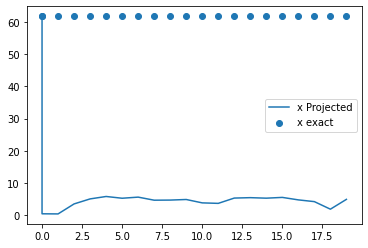

In [43]:
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()
